<h1><center><strong><font color="chillipepper"> Modèle de pricing de biens immobiliers </font></strong></center></h1>
<h1><center><strong><font color="chillipepper"> Business Data Challenge 2023 </font></strong></center></h1>
<h3><center><font color="black"><strong>Models</strong></font></center></h3>
<h3><center><font color="black"> Louise BONHOMME - Antonin FALHER - Blanche Lalouette - Michel Daher Mansour - Clotilde Nietge </font></center></h3>

## I. Libraries

#### Libraries used for the preprocessing steps

In [1]:
import pandas as pd
import numpy as np
import zipfile
#from pandas_profiling import ProfileReport

import datetime, warnings, scipy 
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings(action='once')

In [ ]:
import itertools
import scipy 
import sklearn
from sklearn import ensemble, tree, metrics, preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#ridge, lasso a ajouter ?
from sklearn.datasets import make_regression

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

#from lightgbm import LGBMRegressor

#### Run helpers/useful functions

In [17]:
# Run les fichiers avec les fonctions utiles (helpers)

In [4]:
%run '../Helpers/cleaning.py'

In [5]:
%run '../Helpers/helpers.py'

## II. Loading the datasets

In [ ]:
df_processed_total = pd.read_csv('./dvf_2017_2022_VF_9-2.csv', low_memory = False)

## V. Models implementation

#### In order to implement the models, we have at first to select features.

### V.1 Feature selection

#### We remove any feature that might not help to get better scores. Actually, any feature that is redundant or isn't correlated with the selected label might lead to an overfitting or increase the variance in our calculation. Therefore, those feature should be removed. 

In [291]:
df_processed_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241955 entries, 0 to 1241954
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id_mutation                1241955 non-null  int64  
 1   date_mutation              1241955 non-null  object 
 2   code_type_local            1241955 non-null  float64
 3   code_commune               1241955 non-null  int64  
 4   surface_terrain            1241955 non-null  float64
 5   surface_reelle_bati        1241955 non-null  float64
 6   nombre_pieces_principales  1241955 non-null  float64
 7   valeur_fonciere            1241955 non-null  float64
 8   latitude                   1241955 non-null  float64
 9   longitude                  1241955 non-null  float64
 10  nombre_lots                1241955 non-null  int64  
 11  Prix_m2                    1241955 non-null  float64
 12  Year                       1241955 non-null  int64  
 13  Month       

#### Even if the hot encoding method, which consists in constructing as many variables as the number of unique categories in this variable, improves the F1-score for the random forest by a few tenths, the label encoding approach, which consists in simply converting each value of this column into an integer, is preferred here in order not to degrade too much the results obtained with the other methods and to propose a relevant comparison.

In [292]:
df_model = df_processed_total

df_model['code_commune'] = df_model['code_commune'].astype(str)
df_model['id_mutation'] = df_model['id_mutation'].astype(str)

le = preprocessing.LabelEncoder()
df_model.code_commune=le.fit_transform(df_model.code_commune)
df_model.id_mutation=le.fit_transform(df_model.id_mutation)

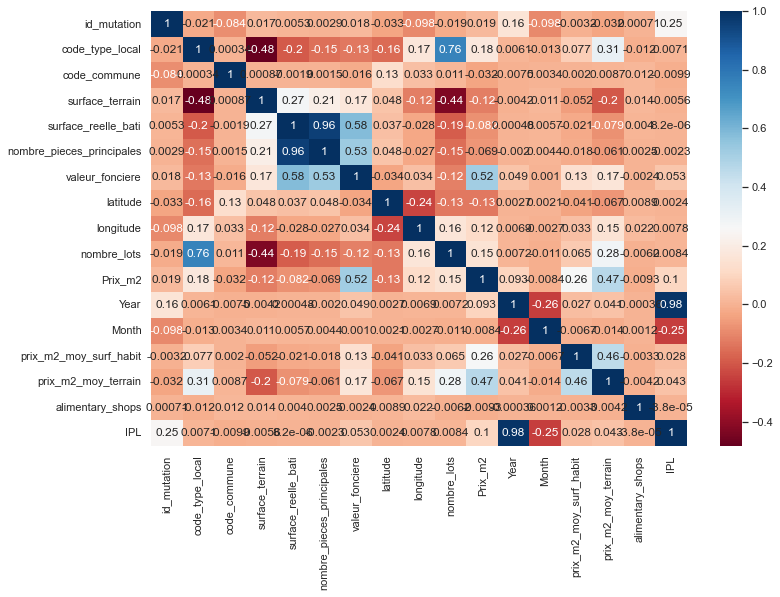

In [293]:
# Computing to correlation among the columns of the data

sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(df_model.corr(), annot=True,cmap='RdBu')
plt.show()

This heatmap describe how much each two variables are corralated.Max correlation is for identical two columns which will give a correlation factor of 1. This is why, for example the diagaonale is 1. 

In [294]:
df_model = df_model.drop(['date_mutation', 'Month', 'nombre_lots'], axis = 1)

#### A second method to select features, multicollinearity is checked using variable inflation factors (VIF) which determine the strength of correlation of a variable with a group of other independent variables in a data set.

In [295]:
df_model = pd.get_dummies(df_model, columns=['statut_urbain', 'Year'], drop_first=True)

In [296]:
df_model

,id_mutation,code_type_local,code_commune,surface_terrain,surface_reelle_bati,nombre_pieces_principales,valeur_fonciere,latitude,longitude,Prix_m2,...,alimentary_shops,IPL,statut_urbain_C,statut_urbain_H,statut_urbain_I,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022
0,1037885,2.0,9252,0.0,60.0,2.0,440000.0,46.156053,-1.155342,7333.333333,...,6,131.23,0,1,0,0,0,0,0,1
1,1037886,2.0,9252,0.0,68.0,3.0,250000.0,46.157436,-1.174097,3676.470588,...,6,131.23,0,1,0,0,0,0,0,1
2,1037893,2.0,9252,0.0,24.0,1.0,115000.0,46.162629,-1.178622,4791.666667,...,6,131.23,0,1,0,0,0,0,0,1
3,1037899,2.0,9252,0.0,106.0,4.0,437381.0,46.160970,-1.161898,4126.235849,...,6,131.23,0,1,0,0,0,0,0,1
4,1037901,2.0,9252,0.0,40.0,2.0,222000.0,46.162913,-1.148197,5550.000000,...,6,131.23,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241950,944462,1.0,9107,750.0,72.0,4.0,90000.0,48.785834,-1.021848,1250.000000,...,5,104.22,0,0,1,0,0,0,0,0
1241951,944129,1.0,8955,500.0,73.0,2.0,92650.0,49.023147,-0.722876,1269.178082,...,0,104.22,0,1,0,0,0,0,0,0
1241952,944178,1.0,8955,1000.0,145.0,5.0,224000.0,48.980922,-0.735359,1544.827586,...,0,104.22,0,1,0,0,0,0,0,0
1241953,944294,1.0,8955,852.0,159.0,6.0,193000.0,49.021772,-0.758351,1213.836478,...,0,104.22,0,1,0,0,0,0,0,0


In [297]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) 
    for i in range(X.shape[1])]
    return(vif)

calc_vif(df_model)

,variables,VIF
0,id_mutation,2.668943
1,code_type_local,1.475371
2,code_commune,1.036934
3,surface_terrain,1.403445
4,surface_reelle_bati,15.517220
5,nombre_pieces_principales,12.711762
6,valeur_fonciere,3.166051
7,latitude,1.126323
8,longitude,1.140313
9,Prix_m2,2.474130


In [298]:
df_model = df_model.drop(['id_mutation' ], axis = 1)

In [299]:
#information on the dataset selected for the models
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241955 entries, 0 to 1241954
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   code_type_local            1241955 non-null  float64
 1   code_commune               1241955 non-null  int64  
 2   surface_terrain            1241955 non-null  float64
 3   surface_reelle_bati        1241955 non-null  float64
 4   nombre_pieces_principales  1241955 non-null  float64
 5   valeur_fonciere            1241955 non-null  float64
 6   latitude                   1241955 non-null  float64
 7   longitude                  1241955 non-null  float64
 8   Prix_m2                    1241955 non-null  float64
 9   prix_m2_moy_surf_habit     1241955 non-null  float64
 10  prix_m2_moy_terrain        1241955 non-null  float64
 11  alimentary_shops           1241955 non-null  int64  
 12  IPL                        1241955 non-null  float64
 13  statut_urbai

### V.2 Splitting the data

In [302]:
# Define the Label and feature colomns
Features = ['code_commune', 'code_type_local', 'surface_terrain', 
            'surface_reelle_bati', 'nombre_pieces_principales' , 
            'prix_m2_moy_surf_habit', 'prix_m2_moy_terrain', 
            'statut_urbain_C', 'statut_urbain_H', 'statut_urbain_I', 
           'Year_2018', 'Year_2019', 'Year_2020', 'Year_2021', 'alimentary_shops']

Label = ['valeur_fonciere']

X = df_model[Features]
Y = df_model[Label]

# Define two test_sizes in order to check which one gives higher performance in prediction.
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X, Y, test_size=0.40, random_state=42)

### V.3 OLS 

The database of the price index is avalaible quaterly on the INSEE website. It works same as the index of consumption prices (IPC), for instance.

In [303]:
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        valeur_fonciere   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                 5.606e+04
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:51:52   Log-Likelihood:            -1.6782e+07
No. Observations:             1241955   AIC:                         3.356e+07
Df Residuals:                 1241939   BIC:                         3.356e+07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

It might be better to use the growth rate instead of the raw index.

### V.3 Random Forest

In [304]:
#Model selection and training
model_rf = RandomForestRegressor(max_depth=10)
model_rf.fit(X_train_0,Y_train_0)

#Prediciton 
y_pred_rf = model_rf.predict(X_test_0)

#Evaluation of results
print('Score for RandomForest',metrics.r2_score(Y_test_0,y_pred_rf))
print('Mean absolute error',mean_absolute_error(Y_test_0,y_pred_rf))

/var/folders/yz/j7zl8ck90j528mms2yj13vhc0000gn/T/ipykernel_7748/51353696.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train_0,Y_train_0)


Score for RandomForest 0.8298865631410686
Mean absolute error 44035.31758172875


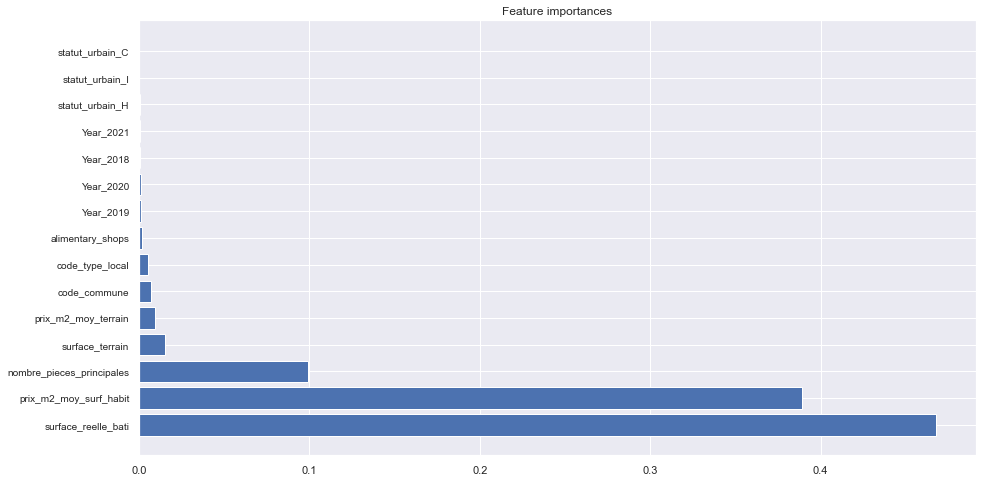

In [305]:
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_0.columns
# plot
nb_features = X_train_0.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()

#### To check if different size_test could perform better, we tried several test sizes the one with test_siwe = 0.2 presented the better perfomance. 

In [ ]:
#Model selection and training
model_rf = RandomForestRegressor(max_depth=10)
model_rf.fit(X_train_1,Y_train_1)

#Prediciton 
y_pred_rf1 = model_rf.predict(X_test_1)

#Evaluation of results
print('Score for RandomForest',metrics.r2_score(Y_test_1,y_pred_rf1))

C:\Users\miche\AppData\Local\Temp\ipykernel_8360\1288837186.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_1,Y_train_1)


Score for RandomForest 0.6060214358818293


### V.4 XGB Regression

In [ ]:
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(n_estimators = 500)
xgbmodel.fit(X_train_0,Y_train_0,
                early_stopping_rounds = 5,
                eval_set = [(X_test_0, Y_test_0)],
                verbose = False)
y_pred_xgb = xgbmodel.predict(X_test_0)
#Evaluation des résultats
print('Score for XGBoost',metrics.r2_score(Y_test_0,y_pred_xgb))
print('Mean absolute error',mean_absolute_error(Y_test_0,y_pred_xgb))



C:\Users\miche\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Score for XGBoost 0.7935213905810381
Mean absolute error 48718.39547032598


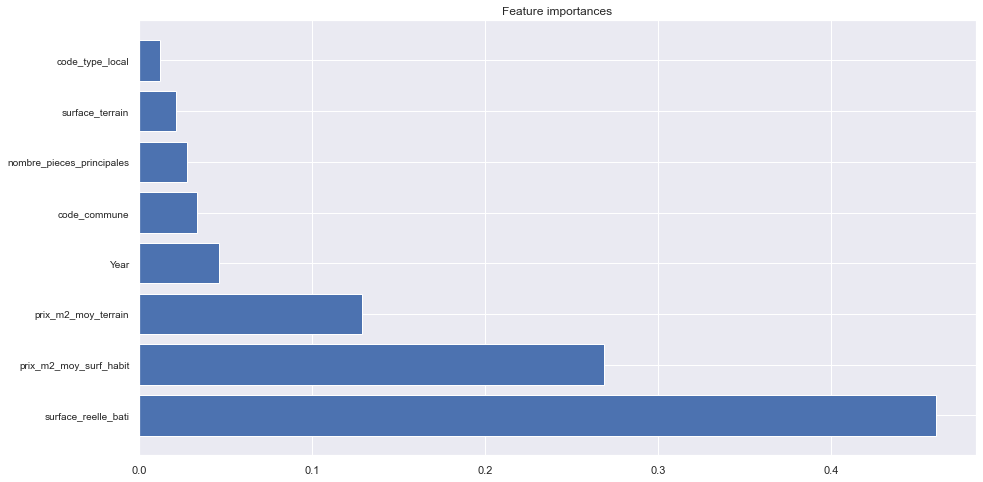

In [ ]:
importances = xgbmodel.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_0.columns
# plot
nb_features = X_train_0.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()

### V.5 LGBM Regressor

In [ ]:
# LGBMRegressor model
LGBMmodel = LGBMRegressor()
LGBMmodel.fit(X_train_0, Y_train_0, eval_set = [(X_test_0, Y_test_0)], early_stopping_rounds = 5, verbose = False)

y_pred_lgbm = LGBMmodel.predict(X_test_0)

#Evaluation des résultats
print('Score for LGBM',metrics.r2_score(Y_test_0,y_pred_lgbm))
print('Mean absolute error', mean_absolute_error(Y_test_0,y_pred_lgbm))


C:\Users\miche\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\miche\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Score for LGBM 0.8218572072158901
Mean absolute error 48194.29127321513


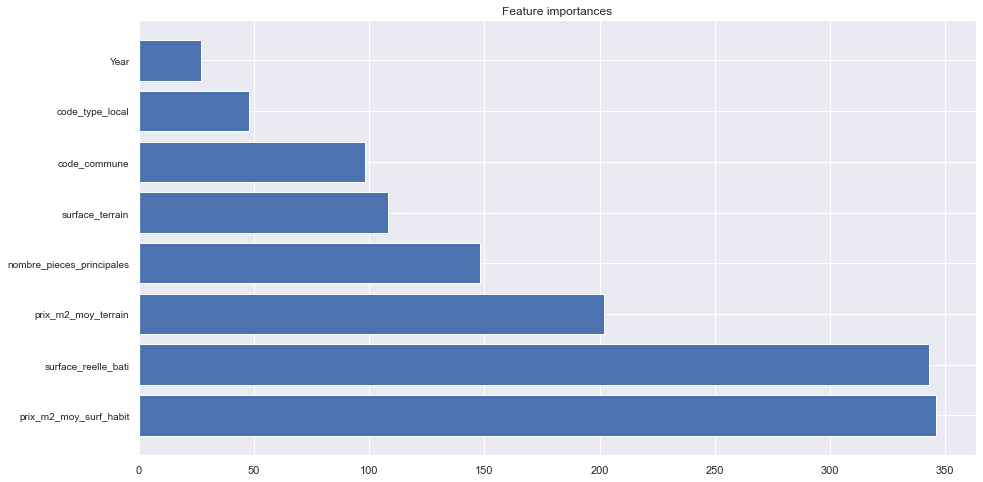

In [ ]:
importances = LGBMmodel.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_0.columns
# plot
nb_features = X_train_0.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()

### V.6 KNeighborsRegressors

In [ ]:
knn = KNeighborsRegressor() # defining regressor
parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # defining parameter space

model_KNN = GridSearchCV(knn, parameters, cv=5)
model_KNN.fit(X_train_0,Y_train_0)
y_pred_KNN = model_KNN.predict(X_test_0)

print('Returned hyperparameter: {}'.format(model_KNN.best_params_))
print('Best regression accuracy in train is: {}'.format(model_KNN.best_score_))
print('Regression accuracy on test is: {}'.format(model_KNN.score(X_test_0, Y_test_0)))
print('Mean absolute error',mean_absolute_error(Y_test_0,y_pred_KNN))

Returned hyperparameter: {'n_neighbors': 5}
Best regression accuracy in train is: 0.5867740101569806
Regression accuracy on test is: 0.6078038266075376
Mean absolute error 53112.00651059443
